In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

from glob import glob

from main import *
from utils.util import *
from utils.model import *
from utils.train import *
from utils.dataset import *

pd.set_option('display.max_columns', 30)
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "3"  # Set the GPU 2 to use

/home/redgreen/miniconda3/envs/ssl/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/redgreen/miniconda3/envs/ssl/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Main

In [3]:
N_max = 20
gamma = 20
NUM_CLASSES = 10
model_seed = 2000

data_dict = load_cifar10()
print(data_dict['label_names'])
if NUM_CLASSES == 2:
    data_dict = cut_class(data_dict, remain = ['bird', 'deer'])

split_obs_mis(data_dict,
              N_max = N_max,
              gamma = gamma,
              seed = 200
              )

# split_obs_mis_with_lr(data_dict, label_weight=np.linspace(-2, -4, 2), seed=100)
print(pd.Series(data_dict['train_obs_labels']).value_counts().sort_index())

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
0     1
1     5
2     2
3    14
4     1
5    10
6     7
7     3
8    20
9     1
Name: count, dtype: int64


In [4]:
data_dict.keys()

dict_keys(['train_labels', 'train', 'test_labels', 'test', 'label_names', 'class2n_obs', 'train_obs', 'train_obs_labels', 'train_mis', 'train_mis_labels', 'labeled'])

In [11]:
data_dict['train'].shape, data_dict['test'].shape, data_dict['label_names'], data_dict['class2n_obs']

((50000, 3072),
 (10000, 3072),
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 {8: 20, 3: 14, 5: 10, 6: 7, 1: 5, 7: 3, 2: 2, 4: 1, 0: 1, 9: 1})

In [14]:
data_dict['train_obs'].shape, data_dict['labeled'].shape

((64, 3072), (50000,))

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [16]:
fix_seed(model_seed, deterministic=True)

# dataset
dataset_obs = Dataset(data_dict, mode='train_obs', use_transform=False)
dataset_mis = Dataset(data_dict, mode='train_mis', use_transform=True)
dataset_mis_none = Dataset(data_dict, mode='train_mis', use_transform=False)
dataset_obs_train, dataset_obs_val = torch.utils.data.random_split(dataset_obs, (0.7, 0.3))
# dataset_mis_train, dataset_mis_val = torch.utils.data.random_split(dataset_mis, (0.7, 0.3))

subset_obs_train_aug = Subset(dataset_obs_train, use_transform=True)
subset_obs_train_norm = Subset(dataset_obs_train, use_transform=False)
subset_obs_val_norm = Subset(dataset_obs_val, use_transform=False)

# add_label_df(label_df, data_dict, dataset_obs_train, dataset_obs_val)

# model param
model = ResNet18_cifar10(device=device, pretrained=False, num_classes=NUM_CLASSES)
# model = AlexNet_cifar10(num_classes=NUM_CLASSES)
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, #0.001 #0.001
#                             momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# result dict
history = {'train_acc': [],
           'train_loss' : [],
           'val_acc' : [],
           'val_loss' : []
           }


n_epoch = 600
train(model, n_epoch = n_epoch, 
      train_set = subset_obs_train_aug,
      val_set = subset_obs_val_norm,
      device=device,
      optimizer = optimizer,
      scheduler = scheduler,
      criterion = criterion,
      history = history,
      every_epoch=50)

# train(model, n_epoch = n_epoch, 
#       train_set = dataset_mis_train,
#       val_set = dataset_mis_val,
#       device=device,
#       optimizer = optimizer,
#       criterion = criterion,
#       history = history)

Epoch:0001/0600, train loss: 2.313, train acc: 0.2667, val loss: 2.29, val acc: 0.1053
Epoch:0051/0600, train loss: 2.008, train acc: 0.3778, val loss: 2.136, val acc: 0.2105
Epoch:0101/0600, train loss: 1.806, train acc: 0.5111, val loss: 2.069, val acc: 0.2105
Epoch:0151/0600, train loss: 1.746, train acc: 0.5556, val loss: 2.082, val acc: 0.2105
Epoch:0201/0600, train loss: 1.695, train acc: 0.5556, val loss: 2.102, val acc: 0.2105
Epoch:0251/0600, train loss: 1.577, train acc: 0.6222, val loss: 2.075, val acc: 0.3158
Epoch:0301/0600, train loss: 1.471, train acc:  0.8, val loss: 2.062, val acc: 0.3158
Epoch:0351/0600, train loss: 1.306, train acc: 0.8667, val loss: 2.054, val acc: 0.2632
Epoch:0401/0600, train loss: 1.179, train acc: 0.8889, val loss: 2.008, val acc: 0.3684
Epoch:0430/0600, train loss: 1.095, train acc:  1.0, val loss: 2.008, val acc: 0.3684


In [29]:
z = 0
1/(1+np.exp(-z))

0.5

In [17]:
## evaluate train_obs
# dataset_obs = Dataset(data_dict, mode='train_obs', use_transform=True)
obs_loss, obs_acc, obs_f1, obs_result = evaluate(model, subset_obs_train_norm, device=device, criterion=criterion, tau=1)
print(f'obs loss: {obs_loss}, obs_f1: {obs_f1}, obs acc: {obs_acc}')

obs_val_loss, obs_val_acc, obs_val_f1, obs_val_result = evaluate(model, subset_obs_val_norm, device=device, criterion=criterion, tau=1)
print(f'obs_val loss: {obs_val_loss}, obs_val_f1: {obs_val_f1}, obs_val acc: {obs_val_acc}')

## evaluate train_mis
mis_loss, mis_acc, mis_f1, mis_result = evaluate(model, dataset_mis, device=device, criterion=criterion, tau=1)
print(f'mis loss: {mis_loss}, mis_f1: {mis_f1}, mis acc: {mis_acc}')

# evaluate trainset
dataset_train = Dataset(data_dict, mode='train', use_transform=True)
train_loss, train_acc, train_f1, train_result = evaluate(model, dataset_train, device=device, criterion=criterion, tau=1)
print(f'train loss: {train_loss}, train_f1: {train_f1}, train acc: {train_acc}')

## evaluate testset
dataset_test = Dataset(data_dict, mode='test', use_transform=True)
test_loss, test_acc, test_f1, test_result = evaluate(model, dataset_test, device=device, criterion=criterion, tau=1)
print(f'test loss: {test_loss}, test_f1: {test_f1}, test acc: {test_acc}')


obs loss: 1.0953935384750366, obs_f1: 0.6142251739405439, obs acc: 0.8888888888888888
obs_val loss: 2.008415699005127, obs_val_f1: 0.1873015873015873, obs_val acc: 0.3684210526315789
mis loss: 2.659059609903399, mis_f1: 0.13223002713249882, mis acc: 0.18856135853892983
train loss: 2.657063837246517, train_f1: 0.13268457833756944, train acc: 0.18926
test loss: 2.6525965249991117, test_f1: 0.12915120898018684, test acc: 0.1835


In [21]:
score_df = pd.DataFrame(obs_result, index=['pred', 'true']).T
score_df['good'] = score_df['pred'] == score_df['true']
score_df.groupby('true')['good'].mean()

true
0    1.0
1    0.5
2    1.0
3    1.0
4    0.0
5    1.0
6    1.0
7    0.0
8    1.0
9    0.0
Name: good, dtype: float64

In [17]:
score_df = pd.DataFrame(mis_result, index=['pred', 'true']).T
score_df['good'] = score_df['pred'] == score_df['true']
score_df.groupby('true')['good'].mean()

true
0    0.087417
1    0.068869
2    0.000000
3    0.375451
4    0.012603
5    0.423848
6    0.345684
7    0.046228
8    0.837751
9    0.010202
Name: good, dtype: float64

In [18]:
score_df = pd.DataFrame(test_result, index=['pred', 'true']).T
score_df['good'] = score_df['pred'] == score_df['true']
score_df.groupby('true')['good'].mean()

true
0    0.088
1    0.062
2    0.000
3    0.344
4    0.012
5    0.426
6    0.366
7    0.041
8    0.821
9    0.006
Name: good, dtype: float64

In [24]:
dataset_obs

10

In [25]:
# raw adjust방법( [ 1 - p(delta) / p(delta) ]과 비교
mis_acc, mis_adjust_acc, mis_f1, mis_adjust_f1, mis_res_prob = compare_raw_adjust(dataset_obs, dataset_mis, n_class=2, 
                                               model=model, device=device, criterion=criterion, tau=1)

test_acc, test_adjust_acc, test_f1, test_adjust_f1, test_res_prob = compare_raw_adjust(dataset_obs, dataset_test, n_class=2, 
                                               model=model, device=device, criterion=criterion, tau=1)

print(f'mis_acc: {mis_acc}, mis_adjust_acc: {mis_adjust_acc}, mis_f1: {mis_f1}, mis_adjust_f1: {mis_adjust_f1}')
print(f'test_acc: {test_acc}, test_adjust_acc: {test_adjust_acc}, test_f1: {test_f1}, test_adjust_f1: {test_adjust_f1}')


res_prob:  [0.0002 0.001  0.0004 0.0028 0.0002 0.002  0.0014 0.0006 0.004  0.0002]
nonres_odds:  [4999.          999.         2499.          356.14285714 4999.
  499.          713.28571429 1665.66666667  249.         4999.        ]
res_prob:  [0.000999   0.00497512 0.00199601 0.01380671 0.000999   0.00990099
 0.00695134 0.00299103 0.01960784 0.000999  ]
nonres_odds:  [1000.          200.          500.           71.42857143 1000.
  100.          142.85714286  333.33333333   50.         1000.        ]
mis_acc: 0.18856135853892983, mis_adjust_acc: 0.1679750080102531, mis_f1: 0.13223002713249882, mis_adjust_f1: 0.15160116717419844
test_acc: 0.1835, test_adjust_acc: 0.1743, test_f1: 0.12915120898018684, test_adjust_f1: 0.15755520111476493


In [26]:
# response model deep model로 고도화시키기..
# X size가 늘어났을 때 잘 작동하게 하기..
response_model = ResponseModel(subset_obs_train_norm, model, device, criterion, 
                               num_classes=NUM_CLASSES, use_pool=True, tau=1)
response_model.iterate(n_iter = 50, dataset_mis=dataset_mis, sampling=False)
# obs_acc, obs_f1 = response_model.evaluate(subset_obs_train_norm, subset_obs_train_norm.y, 
#                                 #   plot=True
#                                   )
mis_acc, mis_f1 = response_model.evaluate(dataset_mis, dataset_mis.y, 
                                # plot=True
                                )
# test_acc, test_f1 = response_model.evaluate(dataset_test, dataset_test.y, 
#                                 #  plot=True
#                                 )
# print(f'obs_acc: {obs_acc}, obs_f1: {obs_f1}')
print(f'mis_acc: {mis_acc}, mis_f1: {mis_f1}')
# print(f'test_acc: {test_acc}, test_f1: {test_f1}')

# 10class

iter(0)>> diff: None, lr_score: None, missing_acc: 0.1886
499405 45.0 0.0 0.002613138992206841
499405 45.0 0.0 0.0025228966571119657
499405 45.0 0.0 0.0033379923226629703
499405 45.0 0.0 0.0016363126529455835
499405 45.0 0.0 0.003341654078463617
499405 45.0 0.0 0.0018938508784610883
499405 45.0 0.0 0.0021702403842643984
499405 45.0 0.0 0.0038526925671359745
499405 45.0 0.0 0.0015582700147823091
499405 45.0 0.0 0.0029164746592885084
odds:  [381.68152 395.36978 298.58127 610.1301  298.253   527.02466 459.77844
 258.55875 640.7373  341.87973]
iter(1)>> diff: None, lr_score: 0.99991, missing_acc: 0.1822
499405 45.0 0.0 0.0031793242948952435
499405 45.0 0.0 0.0029854632018105095
499405 45.0 0.0 0.00519543132402974
499405 45.0 0.0 0.0013801722577535193
499405 45.0 0.0 0.005217554052330385
499405 45.0 0.0 0.0018061719895639335
499405 45.0 0.0 0.00232278644670914
499405 45.0 0.0 0.006810445327249463
499405 45.0 0.0 0.0013304266221674176
499405 45.0 0.0 0.003930776558973949
odds:  [313.53226 33

In [77]:
ary = [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
print(softmax(ary).round(2))
print(softmax(np.log1p(ary)).round(2))

[[0.   0.   0.   0.   0.   0.01 0.03 0.09 0.23 0.63]]
[[0.03 0.05 0.06 0.08 0.09 0.11 0.12 0.14 0.15 0.17]]


In [70]:
def softmax10(ary):
    squared = 1.5**(ary)
    return squared / squared.sum(axis=1, keepdims=True)

softmax10(response_model.out)

array([[0.5581018 , 0.44189826],
       [0.7840895 , 0.21591045],
       [0.73944896, 0.26055104],
       ...,
       [0.68576133, 0.31423864],
       [0.7066203 , 0.29337966],
       [0.7434673 , 0.2565327 ]], dtype=float32)

In [139]:
np.log1p(response_model.y_mis_pred_init).max()

0.69112235

In [43]:
response_model.w_total

array([1.        , 1.        , 1.        , ..., 0.34923452, 0.29614902,
       0.21047327])

<Axes: ylabel='Density'>

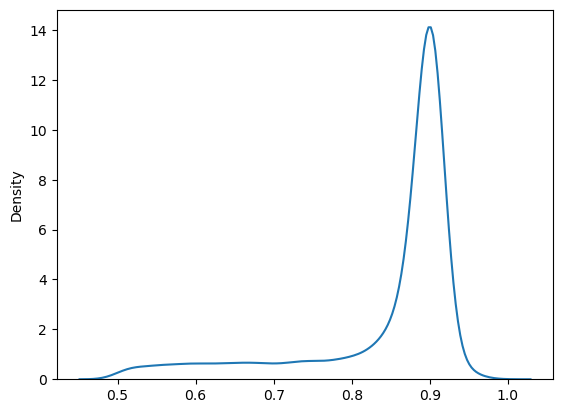

In [12]:
conf = response_model.y_mis_pred_init.max(axis=1)

sns.kdeplot(conf)

In [14]:
# 교수님이 만들어달라고했던 엑셀파일
outcome_pred = evaluate(model, dataset_mis, device=device, criterion=criterion, take_out=True)
mis_adjust_odds = compare_raw_adjust(dataset_obs, dataset_mis, n_class=2, 
                                               model=model, device=device, criterion=criterion,
                                               return_odds=True)
prof_table = pd.DataFrame([dataset_mis.y], index=['true_label']).T
prof_table[['resnet_p(0)', 'resnet_p(1)']] = softmax(outcome_pred)
prof_table[['true_odds(0)', 'true_odds(1)']] = mis_adjust_odds
prof_table[['estimated_odds(0)', 'estimated_odds(1)']] = response_model.nonres_odds
prof_table = prof_table.round(4)

prof_table.to_excel('ssl_professor_cifar_alpha014.xlsx', index=False)


In [17]:
prof_table

,true_label,resnet_p(0),resnet_p(1),true_odds(0),true_odds(1),estimated_odds(0),estimated_odds(1)
0,1,0.6401,0.3599,7.7413,53.3478,14.0808,51.979599
1,1,0.9601,0.0399,7.7413,53.3478,14.0808,51.979599
2,0,0.9291,0.0709,7.7413,53.3478,14.0808,51.979599
3,1,0.9399,0.0601,7.7413,53.3478,14.0808,51.979599
4,0,0.9547,0.0453,7.7413,53.3478,14.0808,51.979599
...,...,...,...,...,...,...,...
9331,1,0.8504,0.1496,7.7413,53.3478,14.0808,51.979599
9332,0,0.9372,0.0628,7.7413,53.3478,14.0808,51.979599
9333,1,0.8727,0.1273,7.7413,53.3478,14.0808,51.979599
9334,0,0.8973,0.1027,7.7413,53.3478,14.0808,51.979599


<Axes: >

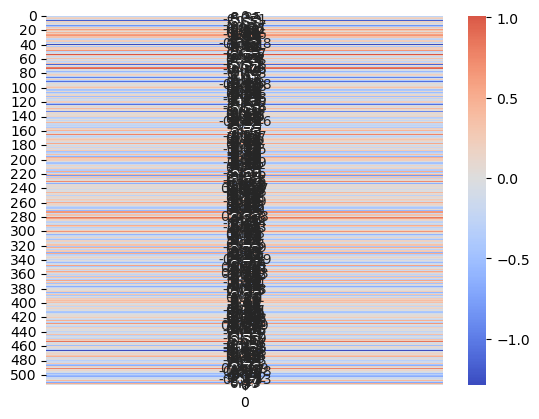

In [122]:
sns.heatmap(response_model.response_model_params[-1][:, np.newaxis], annot=True,
            cmap='coolwarm', center=0)

In [306]:
# model param
ssl_model = ResNet18_cifar10(device=device, pretrained=False, num_classes=NUM_CLASSES)


ssl = SSL(model, response_model, ssl_model, 
          dataset_obs_train, subset_obs_val_norm, dataset_mis_none, dataset_mis, tau=0.9)


criterion = torch.nn.CrossEntropyLoss().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
optimizer = torch.optim.SGD(ssl_model.parameters(), lr=0.01, #0.001 #0.001
                            momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# result dict
history = {'train_acc': [],
           'train_loss' : [],
           'val_acc' : [],
           'val_loss' : []}

n_epoch = 600
ssl.fit(n_epoch = n_epoch,
        device=device,
        optimizer = optimizer,
        scheduler = scheduler,
        criterion = criterion,
        history = history,
        every_epoch=50
        )

# train(model, n_epoch = n_epoch, 
#       train_set = subset_obs_train_aug,
#       val_set = subset_obs_val_norm,
#       device=device,
#       optimizer = optimizer,
#       scheduler = scheduler,
#       criterion = criterion,
#       history = history,
#       every_epoch=50)

Epoch:0001/0600, train loss: 0.2915, train acc: 0.9239, val loss: 0.2166, val acc: 0.9433
[EarlyStopping] (Update) Best Score: 0.94326
[EarlyStopping] (Patience) 1/50, Best: 0.94326, Current: 0.94326, Delta: 0.00000
[EarlyStopping] (Patience) 2/50, Best: 0.94326, Current: 0.94326, Delta: 0.00000
[EarlyStopping] (Patience) 3/50, Best: 0.94326, Current: 0.94326, Delta: 0.00000
[EarlyStopping] (Patience) 4/50, Best: 0.94326, Current: 0.94326, Delta: 0.00000
[EarlyStopping] (Patience) 5/50, Best: 0.94326, Current: 0.94326, Delta: 0.00000
[EarlyStopping] (Patience) 6/50, Best: 0.94326, Current: 0.94326, Delta: 0.00000
[EarlyStopping] (Patience) 7/50, Best: 0.94326, Current: 0.94326, Delta: 0.00000
[EarlyStopping] (Patience) 8/50, Best: 0.94326, Current: 0.94326, Delta: 0.00000
[EarlyStopping] (Patience) 9/50, Best: 0.94326, Current: 0.94326, Delta: 0.00000
[EarlyStopping] (Patience) 10/50, Best: 0.94326, Current: 0.94326, Delta: 0.00000
[EarlyStopping] (Patience) 11/50, Best: 0.94326, Curre

<Axes: >

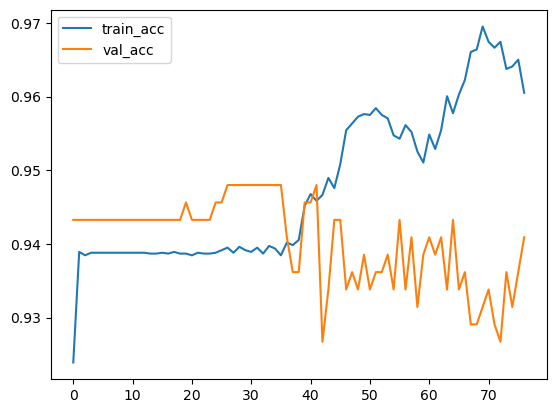

In [310]:
pd.DataFrame(history)[['train_acc', 'val_acc']].plot()

In [308]:
outcome_pred = evaluate(model, dataset_mis, device, criterion, take_out=True).numpy().argmax(axis=1)
ssl_pred = evaluate(ssl_model, dataset_mis, device, criterion, take_out=True).numpy().argmax(axis=1)


print(np.mean(outcome_pred == dataset_mis.y))
print(np.mean(ssl_pred == dataset_mis.y))

0.4954000232910213
0.47164318155351115


In [309]:
outcome_pred = evaluate(model, dataset_test, device, criterion, take_out=True).numpy().argmax(axis=1)
ssl_pred = evaluate(ssl_model, dataset_test, device, criterion, take_out=True).numpy().argmax(axis=1)


print(np.mean(outcome_pred == dataset_test.y))
print(np.mean(ssl_pred == dataset_test.y))

0.5545
0.531


#### under sampling

In [115]:
res_models = []
n_sample = 5
for i in tqdm(range(n_sample)):
    response_model = ResponseModel(subset_obs_train_norm, model, device, criterion, 
                                num_classes=NUM_CLASSES, use_pool=True)
    response_model.iterate(n_iter = 10, dataset_mis=dataset_mis, verbose=True, sampling=True)
    res_models.append(response_model)

preds = []
accs = []
for res_model in tqdm(res_models):
    pred = res_model.predict_proba(dataset_mis)
    acc = np.mean(np.argmax(pred, axis=1) == dataset_mis.y)
    preds.append(pred)
    accs.append(acc)
    
print(accs)
print(np.mean(np.argmax(np.mean(preds, axis=0), axis=1) ==dataset_mis.y))

  0%|          | 0/5 [00:00<?, ?it/s]

iter(0)>> diff: None, lr_score: None, missing_acc: 0.5758
693 231.0 231.0
693 231.0 231.0
iter(1)>> diff: None, lr_score: 0.33333, missing_acc: 0.5801
693 231.0 231.0
693 231.0 231.0
iter(2)>> diff: 0.00271, lr_score: 0.33333, missing_acc: 0.5801
693 231.0 231.0
693 231.0 231.0
iter(3)>> diff: 0.00018, lr_score: 0.33333, missing_acc: 0.5801
693 231.0 231.0
693 231.0 231.0
iter(4)>> diff: 0.00001, lr_score: 0.33333, missing_acc: 0.5801
693 231.0 231.0
693 231.0 231.0
iter(5)>> diff: 0.00000, lr_score: 0.33333, missing_acc: 0.5801
break: convergence
iter(0)>> diff: None, lr_score: None, missing_acc: 0.5714
693 231.0 231.0
693 231.0 231.0
iter(1)>> diff: None, lr_score: 0.33333, missing_acc: 0.5671
693 231.0 231.0
693 231.0 231.0
iter(2)>> diff: 0.00012, lr_score: 0.33333, missing_acc: 0.5671
693 231.0 231.0
693 231.0 231.0
iter(3)>> diff: 0.00001, lr_score: 0.33333, missing_acc: 0.5671
break: convergence
iter(0)>> diff: None, lr_score: None, missing_acc: 0.5758
693 231.0 231.0
693 231.0 

  0%|          | 0/5 [00:00<?, ?it/s]

[0.5617373319544985, 0.5567735263702172, 0.5674250258531541, 0.5616339193381592, 0.5626680455015511]
0.5617373319544985


# Plot

In [46]:
label_df = make_label_df(data_dict, make_sum = False)
add_label_df(label_df, data_dict, dataset_obs_train, dataset_obs_val)

add_sum(label_df)

,label,name,train_labels,test_labels,train_obs_labels,train_mis_labels,train_obs_labels_ratio,train_mis_labels_ratio,dataset_obs_train,dataset_obs_val,dataset_obs_train_ratio,dataset_obs_val_ratio
0,0.0,cat,5000.0,1000.0,30.0,4970.0,0.090909,0.513961,19.0,11.0,0.082251,0.111111
1,1.0,ship,5000.0,1000.0,300.0,4700.0,0.909091,0.486039,212.0,88.0,0.917749,0.888889
sum,1.0,-,10000.0,2000.0,330.0,9670.0,1.000000,1.000000,231.0,99.0,1.000000,1.000000


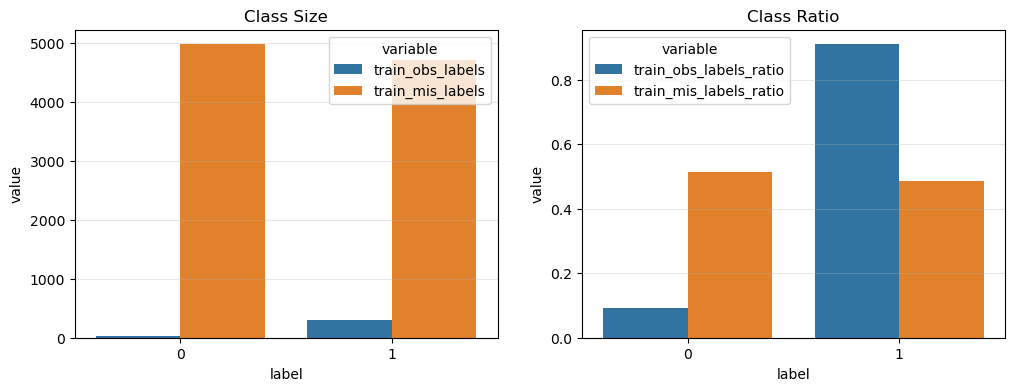

In [524]:
label_df_melt = label_df[['label', 'train_obs_labels', 'train_mis_labels']].melt(id_vars='label')
label_df_melt_ratio = label_df[['label', 'train_obs_labels_ratio', 'train_mis_labels_ratio']].melt(id_vars='label')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(data=label_df_melt, x='label', y='value', hue='variable', ax=axes[0])
sns.barplot(data=label_df_melt_ratio, x='label', y='value', hue='variable', ax=axes[1])
axes[0].grid(axis='y', alpha=0.3)
axes[1].grid(axis='y', alpha=0.3)

axes[0].set_title('Class Size')
axes[1].set_title('Class Ratio')

plt.show()

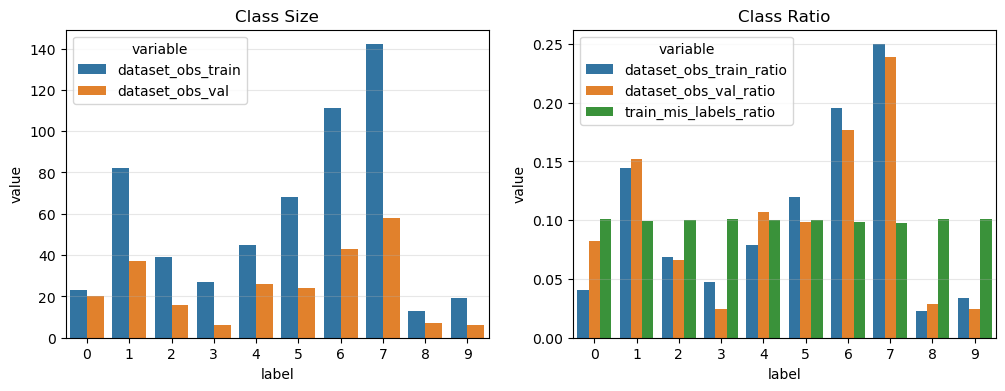

,dataset_obs_train,dataset_obs_val,train_mis_labels
0,23,20,4957
1,82,37,4881
2,39,16,4945
3,27,6,4967
4,45,26,4929
5,68,24,4908
6,111,43,4846
7,142,58,4800
8,13,7,4980
9,19,6,4975


dataset_obs_train      569
dataset_obs_val        243
train_mis_labels     49188
dtype: int64

In [16]:
label_df_melt = label_df[['label', 'dataset_obs_train', 'dataset_obs_val']].melt(id_vars='label')
label_df_melt_ratio = label_df[['label', 'dataset_obs_train_ratio', 'dataset_obs_val_ratio', 'train_mis_labels_ratio']].melt(id_vars='label')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(data=label_df_melt, x='label', y='value', hue='variable', ax=axes[0])
sns.barplot(data=label_df_melt_ratio, x='label', y='value', hue='variable', ax=axes[1])
axes[0].grid(axis='y', alpha=0.3)
axes[1].grid(axis='y', alpha=0.3)

axes[0].set_title('Class Size')
axes[1].set_title('Class Ratio')

plt.show()
display(label_df[['dataset_obs_train', 'dataset_obs_val', 'train_mis_labels']])
display(label_df[['dataset_obs_train', 'dataset_obs_val', 'train_mis_labels']].sum())

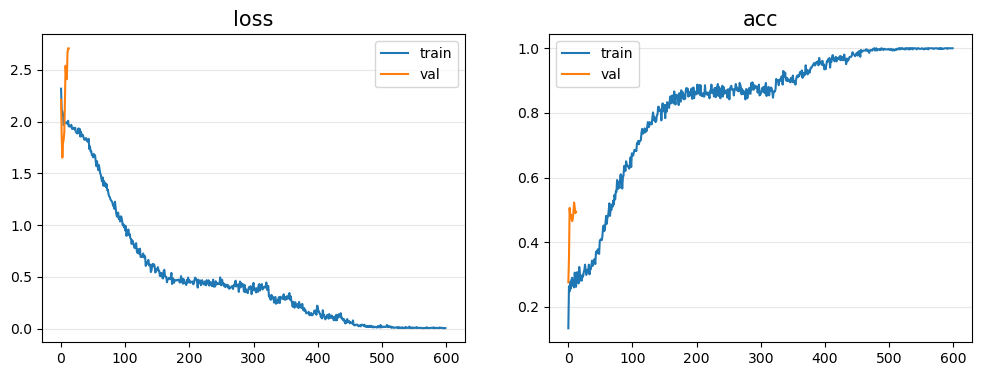

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_loss(history, axes[0]); plot_acc(history, axes[1])

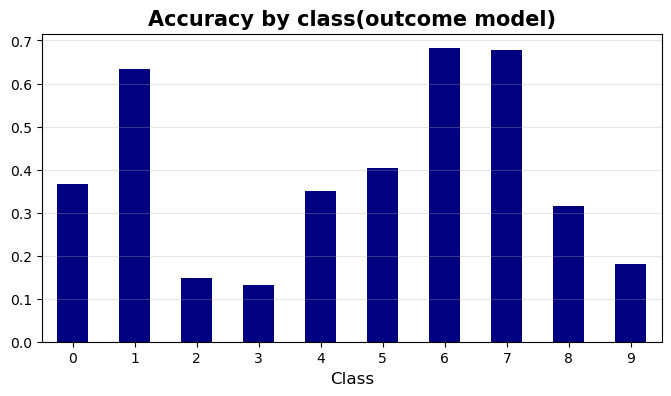

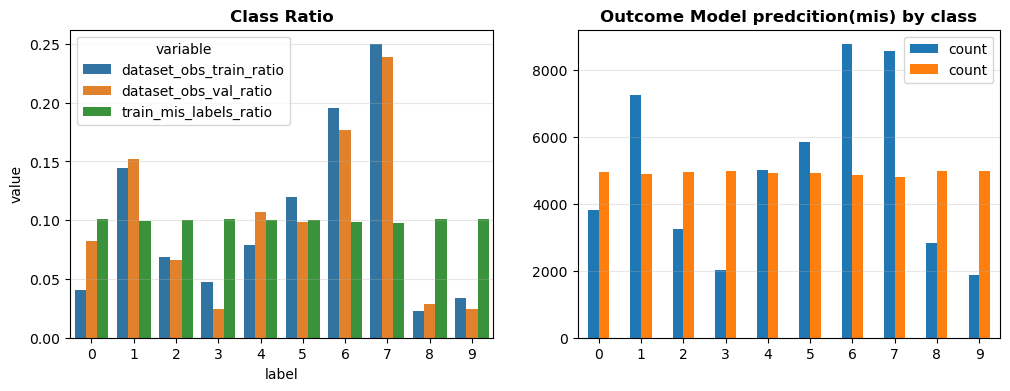

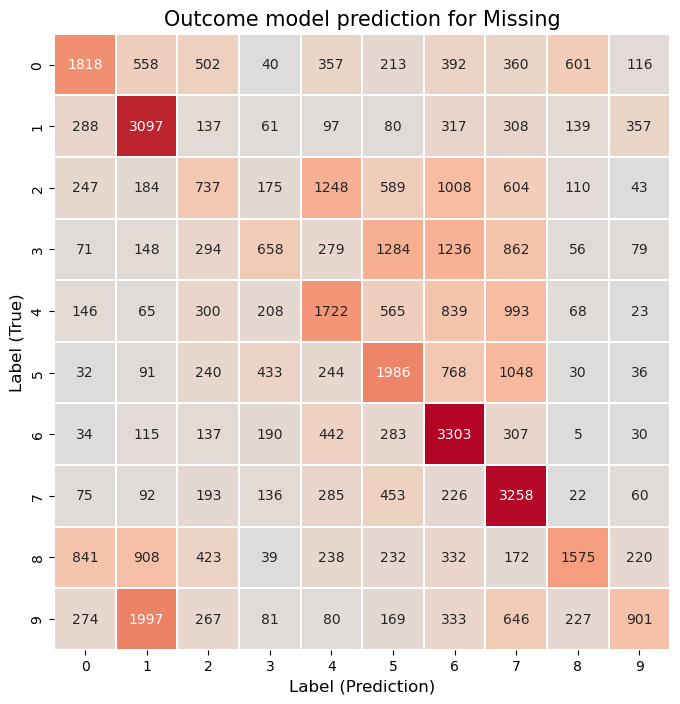

In [27]:
from sklearn.metrics import confusion_matrix

result_df = pd.DataFrame(mis_result, index=['pred', 'true']).T
# vcs = []
# for col in result_df.columns:
#     vc = result_df[col].value_counts()
#     vcs.append(vc)

result_df['correct'] = result_df['pred'] == result_df['true']
class2acc = result_df.groupby('true')['correct'].agg(('sum', 'count')).apply(lambda x: x['sum']/x['count'], axis=1)

class2acc.plot.bar(color='navy', figsize=(8, 4))
plt.title('Accuracy by class(outcome model)', size=15, weight='bold')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.xlabel('Class', size=12)
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(data=label_df_melt_ratio, x='label', y='value', hue='variable', ax=axes[0])
pd.concat(vcs, axis=1).sort_index().plot.bar(ax=axes[1])

axes[0].grid(axis='y', alpha=0.3)
axes[1].grid(axis='y', alpha=0.3)

axes[0].set_title('Class Ratio', size=12, weight='bold')
axes[1].set_title('Outcome Model predcition(mis) by class', size=12, weight='bold')

plt.xticks(rotation=0)
plt.show()

plt.figure(figsize=(10, 8))
cm = confusion_matrix(result_df['true'], result_df['pred'])
sns.heatmap(cm,
         vmin=0, vmax=cm.max().max(), center=0,
          cmap='coolwarm',
          annot=True, fmt='d',
          linewidth=0.1, square=True, cbar=False,
         )
plt.xlabel('Label (Prediction)', size=12)
plt.ylabel('Label (True)', size=12)
plt.title('Outcome model prediction for Missing', size=15)
plt.show()

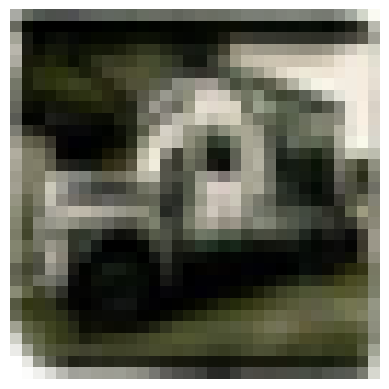

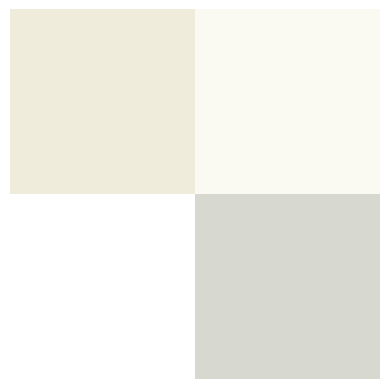

In [20]:
temp = Dataset(data_dict, mode='train_obs', use_transform=False)
plt.imshow(temp[0][0])
plt.axis('off')
plt.show()
pooled = nn.MaxPool2d(kernel_size=16)(torch.tensor(temp[0][0].transpose(2, 0, 1), dtype=torch.float)).numpy().transpose(1, 2, 0)
plt.imshow(pooled/255)
plt.axis('off')
plt.show()

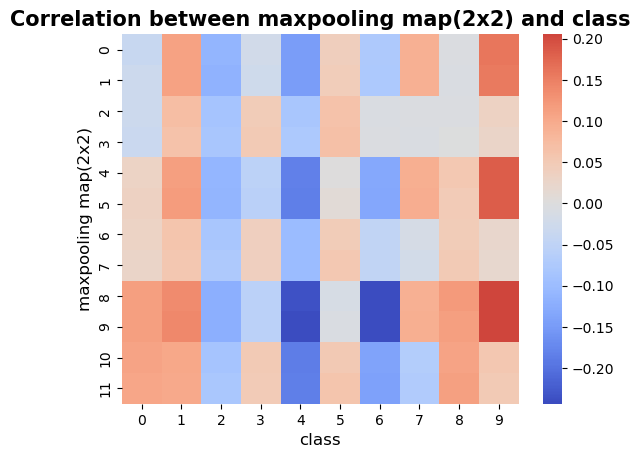

In [26]:
# X_1 = pd.DataFrame([[val.item() for val in dataset_train[i][0].mean(dim=(1, 2))] for i in range(len(dataset_train))], columns=['r', 'g', 'b'])
# X_1 = pd.DataFrame([[val.item() for val in nn.MaxPool2d(kernel_size=16)(dataset_train[i][0]).flatten()] for i in range(len(dataset_train))], 
#                    columns=[channel+str(i) for channel in ['r', 'g', 'b'] for i in range(4)])

X_1 =  pd.DataFrame(response_model._preprocess_X(dataset_train))
X_1[[str(num) for num in range(NUM_CLASSES)]] = F.one_hot(torch.tensor(dataset_train.y), num_classes=NUM_CLASSES)

sns.heatmap(X_1.corr().iloc[:-NUM_CLASSES, -NUM_CLASSES:], cmap='coolwarm', center=0)
plt.xlabel('class', size=12)
plt.ylabel('maxpooling map(2x2)', size=12)
plt.title('Correlation between maxpooling map(2x2) and class', size=15, weight='bold')
plt.show()